In [ ]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

# 1.1 Load dataset
df = pd.read_csv("/content/IMDB Dataset.csv")
df.head()

# 1.2 Explore dataset structure
print("Number of records:", df.shape[0])
print("Number of columns:", df.shape[1])
print("\nClass balance:\n", df['sentiment'].value_counts())
print("\nSample reviews:\n", df['review'].head())



Number of records: 50000
Number of columns: 2

Class balance:
 sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Sample reviews:
 0    One of the other reviewers has mentioned that ...
1    A wonderful little production. <br /><br />The...
2    I thought this was a wonderful way to spend ti...
3    Basically there's a family where a little boy ...
4    Petter Mattei's "Love in the Time of Money" is...
Name: review, dtype: object


In [ ]:
# 1.3 Basic preprocessing function
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r"<.*?>", "", text)
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords & lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
df['clean_review'] = df['review'].apply(clean_text)

# Quick check
df[['review','clean_review']].head()

,review,clean_review
0,One of the other reviewers has mentioned that ...,one reviewer mentioned watching 1 oz episode y...
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love time money visually stunni...


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Using TF-IDF with bigrams
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = tfidf.fit_transform(df['clean_review'])
y = df['sentiment'].map({'positive':1, 'negative':0})

print("Shape of TF-IDF matrix:", X.shape)

Shape of TF-IDF matrix: (50000, 5000)



Logistic Regression:
               precision    recall  f1-score   support

           0       0.90      0.87      0.89      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



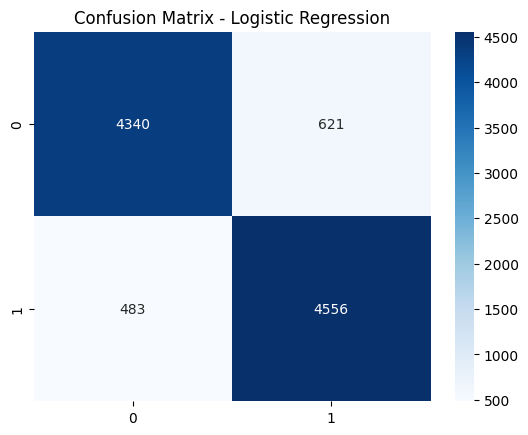


Naive Bayes:
               precision    recall  f1-score   support

           0       0.87      0.84      0.85      4961
           1       0.85      0.87      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



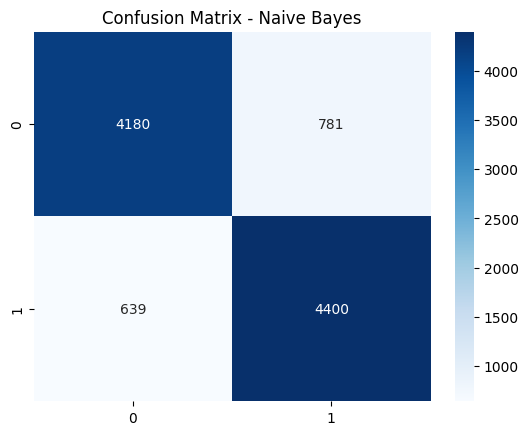


SVM:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      4961
           1       0.88      0.89      0.89      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



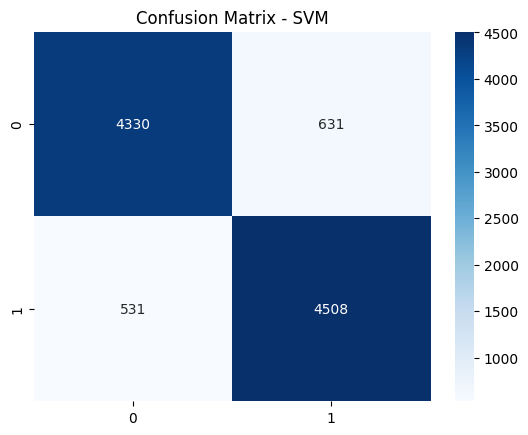

,Accuracy,Precision,Recall,F1-score
Logistic Regression,0.8896,0.880046,0.904148,0.891934
Naive Bayes,0.8580,0.849257,0.873189,0.861057
SVM,0.8838,0.877213,0.894622,0.885832


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "SVM": LinearSVC()
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred)
    }
    print(f"\n{name}:\n", classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

pd.DataFrame(results).T

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

# Parameter grid for optimization
param_grid = {
    'tfidf__max_features': [5000, 10000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__C': [0.1, 1, 10]
}

grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid.fit(df['clean_review'], y)

print("Best parameters:", grid.best_params_)
print("Best accuracy:", grid.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters: {'clf__C': 1, 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}
Best accuracy: 0.8912400055131022


In [17]:
final_model = grid.best_estimator_

# Testing on unseen reviews
test_samples = [
    "I absolutely loved this movie! It was fantastic.",
    "This was the worst film I've ever seen.",
    "The plot was predictable but still entertaining.",
    "Amazing acting and a great story!",
    "I wouldn't recommend this to anyone."
]

predictions = final_model.predict(test_samples)

for review, pred in zip(test_samples, predictions):
    label = "Positive" if pred == 1 else "Negative"
    print(f"\nReview: {review}\nPredicted Sentiment: {label}")

# Overall summary
# Re-vectorize the data using the best TfidfVectorizer from the pipeline
best_tfidf = final_model.named_steps['tfidf']
X_revectorized = best_tfidf.transform(df['clean_review'])

# Split the re-vectorized data
X_train_revec, X_test_revec, y_train, y_test = train_test_split(X_revectorized, y, test_size=0.2, random_state=42)

# Use the classifier from the pipeline to predict on the re-vectorized test set
final_preds = final_model.named_steps['clf'].predict(X_test_revec)
print("\nFinal Model Performance on Test Set:")
print(classification_report(y_test, final_preds))


Review: I absolutely loved this movie! It was fantastic.
Predicted Sentiment: Positive

Review: This was the worst film I've ever seen.
Predicted Sentiment: Negative

Review: The plot was predictable but still entertaining.
Predicted Sentiment: Positive

Review: Amazing acting and a great story!
Predicted Sentiment: Positive

Review: I wouldn't recommend this to anyone.
Predicted Sentiment: Positive

Final Model Performance on Test Set:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      4961
           1       0.92      0.94      0.93      5039

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

